In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import os

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping 

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
with_mask_dir = "/content/drive/My Drive/Machine Learning/Tubes/Dataset/with_mask"
without_mask_dir= "/content/drive/My Drive/Machine Learning/Tubes/Dataset/without_mask"
filepaths = []
labels= []
dict_list = [with_mask_dir, without_mask_dir]
for i, j in enumerate(dict_list):
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('with_mask')
        else:
          labels.append('without_mask') 
    
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
mask_data = pd.concat([Fseries,Lseries], axis=1)
mask_df = pd.DataFrame(mask_data)
print(mask_df.head())
print(mask_df["labels"].value_counts())

                                           filepaths     labels
0  /content/drive/My Drive/Machine Learning/Tubes...  with_mask
1  /content/drive/My Drive/Machine Learning/Tubes...  with_mask
2  /content/drive/My Drive/Machine Learning/Tubes...  with_mask
3  /content/drive/My Drive/Machine Learning/Tubes...  with_mask
4  /content/drive/My Drive/Machine Learning/Tubes...  with_mask
with_mask       2165
without_mask    1930
Name: labels, dtype: int64


In [10]:
#shape of datatset
mask_df.shape

(4095, 2)

In [11]:
train_set, test_images = train_test_split(mask_df, test_size=0.3, random_state=42)
test_set, val_set = train_test_split(test_images, test_size=0.2, random_state=42)

In [12]:
#Generate batches of tensor image data with real-time data augmentation.
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)

train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='grayscale',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )

test = image_gen.flow_from_dataframe(dataframe= test_set,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='grayscale',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )

val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'grayscale',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 2863 validated image filenames belonging to 2 classes.
Found 983 validated image filenames belonging to 2 classes.
Found 246 validated image filenames belonging to 2 classes.


In [13]:
classes=list(train.class_indices.keys())
print (classes)

['with_mask', 'without_mask']


In [16]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    history_df.loc[0:, ['loss', 'val_loss']].plot()
    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()

#Model 2.1

In [17]:
import keras
from tensorflow.keras import layers

CNN_2 = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(244,244,1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

CNN_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
CNN_2.optimizer.lr=0.001

CNN_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 244, 244, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 122, 122, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 32)        0

In [18]:
history_CNN = CNN_2.fit(train, validation_data= val, epochs=15,verbose=1)

Epoch 1/15
90/90 [==============================] - 1183s 13s/step - loss: 0.5167 - accuracy: 0.7408 - val_loss: 0.3369 - val_accuracy: 0.8577
Epoch 2/15
90/90 [==============================] - 229s 3s/step - loss: 0.3268 - accuracy: 0.8557 - val_loss: 0.2004 - val_accuracy: 0.9390
Epoch 3/15
90/90 [==============================] - 230s 3s/step - loss: 0.2105 - accuracy: 0.9127 - val_loss: 0.1892 - val_accuracy: 0.9187
Epoch 4/15
90/90 [==============================] - 229s 3s/step - loss: 0.1459 - accuracy: 0.9455 - val_loss: 0.1213 - val_accuracy: 0.9675
Epoch 5/15
90/90 [==============================] - 228s 3s/step - loss: 0.1189 - accuracy: 0.9553 - val_loss: 0.1154 - val_accuracy: 0.9634
Epoch 6/15
90/90 [==============================] - 227s 3s/step - loss: 0.0809 - accuracy: 0.9714 - val_loss: 0.1135 - val_accuracy: 0.9593
Epoch 7/15
90/90 [==============================] - 227s 3s/step - loss: 0.0686 - accuracy: 0.9762 - val_loss: 0.1522 - val_accuracy: 0.9472
Epoch 8/15


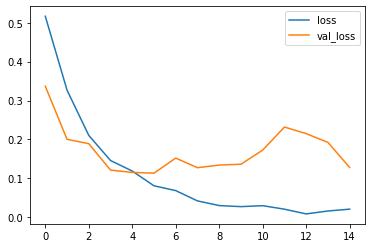

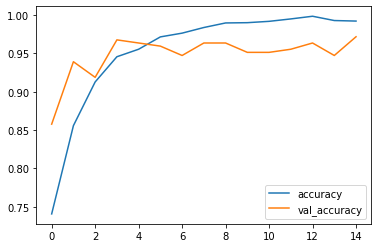

In [19]:
#resuts from model 1
plot_loss_and_accuracy(history_CNN.history)

In [20]:
pred = CNN_2.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

y_test = test_set.labels # set y_test to the expected output
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

   with_mask       0.93      0.97      0.95       535
without_mask       0.96      0.92      0.94       448

    accuracy                           0.94       983
   macro avg       0.95      0.94      0.94       983
weighted avg       0.94      0.94      0.94       983



In [29]:
import json

target_dir = '/content/drive/My Drive/Machine Learning/Tubes/Model 2/Model 2.1'

# simpan history model 2.1
history_dict = history_CNN.history
json.dump(history_dict, open(target_dir + '/history_model_2.1.json', 'w'))

# simpan model 2.1 dan weight-nya
CNN_2.save(target_dir + '/model_2.1.h5')
CNN_2.save_weights(target_dir + '/model_2.1_weights.h5')

#Model 2.2


In [21]:
from tensorflow.keras import layers

MyCnn = tf.keras.models.Sequential([
  layers.Conv2D(32, 3, activation='relu',input_shape=(244,244,1)),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.GlobalAveragePooling2D(),
  layers.Dense(256, activation='relu'),
  layers.Dense(2, activation= 'softmax')
])

MyCnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

MyCnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 242, 242, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 119, 119, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 57, 57, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)              

In [22]:
history_my_CNN = MyCnn.fit(train, validation_data= val, epochs=15,verbose=1)

Epoch 1/15
90/90 [==============================] - 271s 3s/step - loss: 0.6790 - accuracy: 0.5802 - val_loss: 0.6366 - val_accuracy: 0.7073
Epoch 2/15
90/90 [==============================] - 269s 3s/step - loss: 0.6287 - accuracy: 0.6479 - val_loss: 0.5713 - val_accuracy: 0.6951
Epoch 3/15
90/90 [==============================] - 267s 3s/step - loss: 0.5172 - accuracy: 0.7419 - val_loss: 0.4304 - val_accuracy: 0.8211
Epoch 4/15
90/90 [==============================] - 267s 3s/step - loss: 0.4237 - accuracy: 0.8170 - val_loss: 0.3811 - val_accuracy: 0.8496
Epoch 5/15
90/90 [==============================] - 266s 3s/step - loss: 0.3556 - accuracy: 0.8453 - val_loss: 0.3319 - val_accuracy: 0.8496
Epoch 6/15
90/90 [==============================] - 267s 3s/step - loss: 0.2938 - accuracy: 0.8781 - val_loss: 0.3017 - val_accuracy: 0.8699
Epoch 7/15
90/90 [==============================] - 270s 3s/step - loss: 0.2870 - accuracy: 0.8757 - val_loss: 0.3487 - val_accuracy: 0.8496
Epoch 8/15
90

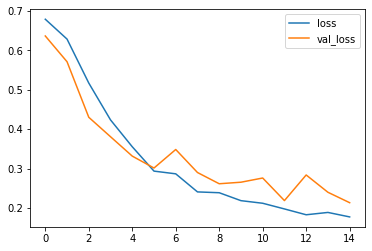

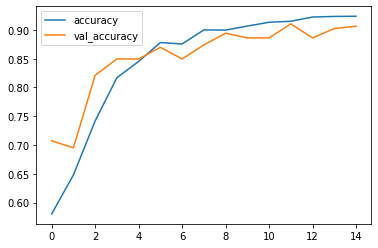

In [23]:
plot_loss_and_accuracy(history_my_CNN.history)

In [30]:
import json

target_dir = '/content/drive/My Drive/Machine Learning/Tubes/Model 2/Model 2.2'

# simpan history model 2.2
history_dict = history_my_CNN.history
json.dump(history_dict, open(target_dir + '/history_model_2.2.json', 'w'))

# simpan model 2.2 dan weight-nya
MyCnn.save(target_dir + '/model_2.2.h5')
MyCnn.save_weights(target_dir + '/model_2.2_weights.h5')

#Confusion Matrix

In [24]:
pred_mod2 = MyCnn.predict(test)
pred_mod2 = np.argmax(pred_mod2, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2_mod2 = [labels[k] for k in pred_mod2]

y_test = test_set.labels # set y_test to the expected output
print(classification_report(y_test, pred2_mod2))

              precision    recall  f1-score   support

   with_mask       0.93      0.93      0.93       535
without_mask       0.91      0.91      0.91       448

    accuracy                           0.92       983
   macro avg       0.92      0.92      0.92       983
weighted avg       0.92      0.92      0.92       983



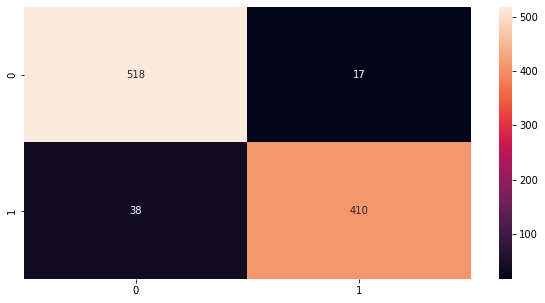

In [25]:
# model 1
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')

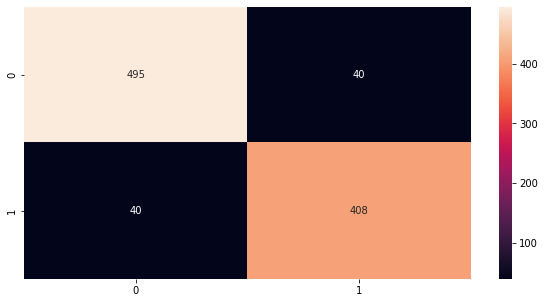

In [26]:
# model 2
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2_mod2)
sns.heatmap(cm, annot=True, fmt = 'g')